In [1]:
%cd ../tti-explorer
%pip install -q .

/home/gejinchen/Desktop/l48/project/tti-explorer
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tti
from tti import simulation

import GPy
import GPyOpt
from numpy.random import seed
import matplotlib

import numpy as np

# Use parameters in config as cost

In [3]:
# The base function that reuturns R
def f(x):
    # x has shape (1, 2)
    theta = x[0]
    config_details = {0 : {"name": "compliance", "config": "policy_config"}, 
                      1 : {"name": "go_to_school_prob", "config": "policy_config"}} 
    output_dict = simulation(theta, config_details)
    reduced_r = output_dict['Effective R']
    return reduced_r

In [4]:
def cost(x):
    compliance = x[0,0]
    go_to_school_prob = x[0,1]
    
    # Use x**2 means the hgiher the compliance, the harder to increase compliance
    compliance_cost = compliance**2
    # Use 1/x means the lower the go_to_school_prob, the harder to decrease go_to_school_prob.(Maybe not true?)
    # Plus 0.001 to avoid division by 0
    go_to_school_prob_cost = 1 / (go_to_school_prob+0.001)
    
    # Weighted by coefficients
    return compliance_cost + 0.05*go_to_school_prob_cost

In [16]:
def composite_f(x):
    coeff = 1.5
    return f(x) + coeff*cost(x)

In [17]:
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)},
         {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)}]

# Use TTI output as cost

In [7]:
def composite_f(x):
    # x has shape (1, 2)
    theta = x[0]
    config_details = {0 : {"name": "compliance", "config": "policy_config"}} 
    output_dict = simulation(theta, config_details)
    reduced_r = output_dict['Effective R']
    tests = output_dict['# Tests Needed']
    
    # Weighted by coefficients
    return reduced_r + 0.01*tests

In [8]:
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)}]

# Do optimization

In [18]:
# Creates GPyOpt object with the model and anquisition fucntion
seed(42)
myBopt2D = GPyOpt.methods.BayesianOptimization(composite_f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='EI',  
                                              normalize_Y = True,
                                              acquisition_weight = 2)    

In [19]:
max_iter = 40  # maximum time 40 iterations
max_time = 120  # maximum time 120 seconds

myBopt2D.run_optimization(max_iter, max_time, verbosity=True, eps=1e-06) 


num acquisition: 1, time elapsed: 3.66s



num acquisition: 2, time elapsed: 7.26s



num acquisition: 3, time elapsed: 10.07s



num acquisition: 4, time elapsed: 13.54s



num acquisition: 5, time elapsed: 16.37s



num acquisition: 6, time elapsed: 20.20s



num acquisition: 7, time elapsed: 23.33s



num acquisition: 8, time elapsed: 27.26s



num acquisition: 9, time elapsed: 30.73s



num acquisition: 10, time elapsed: 34.17s



num acquisition: 11, time elapsed: 37.74s



num acquisition: 12, time elapsed: 41.56s



num acquisition: 13, time elapsed: 44.87s



num acquisition: 14, time elapsed: 47.94s



num acquisition: 15, time elapsed: 51.19s



num acquisition: 16, time elapsed: 55.20s



num acquisition: 17, time elapsed: 59.29s



num acquisition: 18, time elapsed: 62.92s



num acquisition: 19, time elapsed: 65.66s



num acquisition: 20, time elapsed: 69.20s



num acquisition: 21, time elapsed: 72.83s



num acquisition: 22, time elapsed: 75.66s



num acquisition: 23, time elapsed: 78.92s



num acquisition: 24, time elapsed: 82.46s



num acquisition: 25, time elapsed: 86.59s



num acquisition: 26, time elapsed: 90.03s



num acquisition: 27, time elapsed: 93.26s



num acquisition: 28, time elapsed: 96.72s



num acquisition: 29, time elapsed: 100.55s



num acquisition: 30, time elapsed: 104.29s



num acquisition: 31, time elapsed: 107.79s



num acquisition: 32, time elapsed: 111.21s



num acquisition: 33, time elapsed: 115.14s



num acquisition: 34, time elapsed: 118.83s



num acquisition: 35, time elapsed: 122.24s


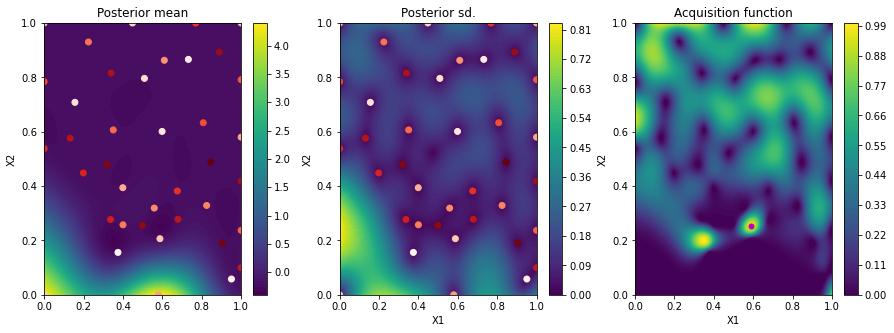

In [20]:
myBopt2D.plot_acquisition()

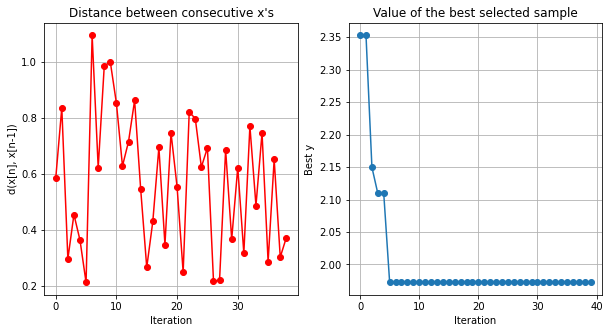

In [21]:
myBopt2D.plot_convergence()

In [22]:
# Optimum of x or argmin
myBopt2D.x_opt

array([0.508916  , 0.79624078])

In [23]:
# Optimum of fx or min
myBopt2D.fx_opt

1.9723140889041249

In [24]:
# Optima of R and cost, only for when using parameters in config as cost
x_opt = np.expand_dims(myBopt2D.x_opt, axis=0)
print ("R: ", f(x_opt))
print ("cost: ", cost(x_opt))
print ("composite: ", composite_f(x_opt))


R:  1.4897463775097555
cost:  0.32171180759624635



composite:  1.9723140889041249
